In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
import warnings
import time
import statsmodels.api as sm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

warnings.filterwarnings('ignore')

COVID = pd.read_excel('./owid-covid-data.xlsx')
COVID = COVID.fillna(0)
COVID.head()

In [3]:
COVID.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

## 한국 기준

In [14]:
COVID_KOR = COVID[COVID['location'] == 'South Korea']

In [15]:
X = COVID_KOR[['total_cases',
 'excess_mortality_cumulative_absolute',
 'icu_patients',
 'total_vaccinations',
 'stringency_index',
 'new_cases',
 'weekly_hosp_admissions',
 'weekly_icu_admissions',
 'positive_rate',
 'reproduction_rate',
'new_tests',
'total_tests']]
y = COVID_KOR['new_deaths']

In [16]:
kor_gb_reg = GradientBoostingRegressor(random_state=13)
kor_gb_reg.fit(X, y)

GradientBoostingRegressor(random_state=13)

## GBM의 score 확인

In [17]:
model = GradientBoostingRegressor()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.9945211611775414
0.8667981552994456


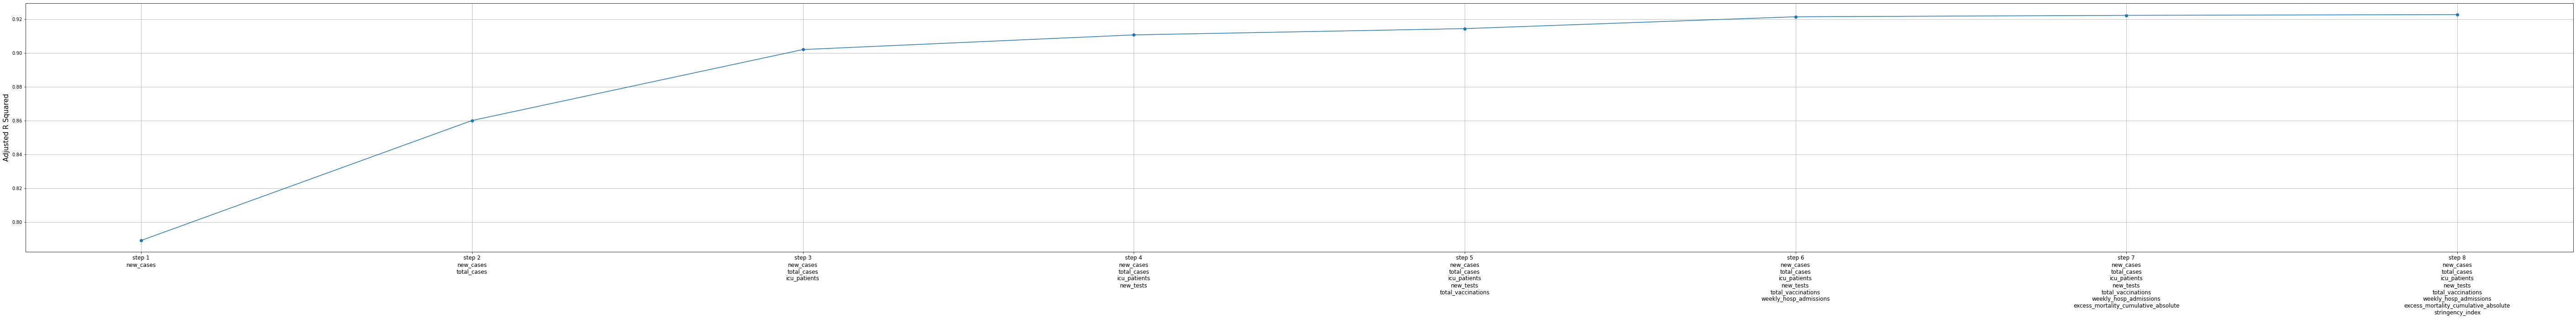

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

def stepwise_feature_selection(X_train, y_train, variables=X_train.columns.tolist() ): 
    import statsmodels.api as sm 
    import matplotlib.pyplot as plt 
    import warnings 
    warnings.filterwarnings("ignore") 
    y = y_train ## 반응 변수 
    selected_variables = [] ## 선택된 변수들 
    sl_enter = 0.05 
    sl_remove = 0.05 
    sv_per_step = [] ## 각 스텝별로 선택된 변수들 
    adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수 
    steps = [] ## 스텝 
    step = 0 
    while len(variables) > 0: 
        remainder = list(set(variables) - set(selected_variables)) 
        pval = pd.Series(index=remainder) ## 변수의 p-value ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 ## 선형 모형을 적합한다. 
        for col in remainder: 
            X = X_train[selected_variables+[col]] 
            X = sm.add_constant(X) 
            model = sm.OLS(y,X).fit(disp=0) 
            pval[col] = model.pvalues[col] 
            min_pval = pval.min() 
        if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함 
            selected_variables.append(pval.idxmin()) ## 선택된 변수들에대해서 ## 어떤 변수를 제거할지 고른다. 
            while len(selected_variables) > 0: 
                selected_X = X_train[selected_variables] 
                selected_X = sm.add_constant(selected_X) 
                selected_pval = sm.OLS(y,selected_X).fit(disp=0).pvalues[1:] ## 절편항의 p-value는 뺀다 
                max_pval = selected_pval.max() 
                if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외 
                    remove_variable = selected_pval.idxmax() 
                    selected_variables.remove(remove_variable) 
                else: 
                    break 
            step += 1 
            steps.append(step) 
            adj_r_squared = sm.OLS(y,sm.add_constant(X_train[selected_variables])).fit(disp=0).rsquared_adj 
            adjusted_r_squared.append(adj_r_squared) 
            sv_per_step.append(selected_variables.copy()) 
        else: 
            break 
    fig = plt.figure(figsize=(100,10)) 
    fig.set_facecolor('white') 
    font_size = 15 
    plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12) 
    
    plt.plot(steps,adjusted_r_squared, marker='o') 
    
    plt.ylabel('Adjusted R Squared',fontsize=font_size) 
    plt.grid(True) 
    plt.show() 

    return selected_variables 
selected_variables = stepwise_feature_selection(X_train, y_train)

## RMSE값, r2값 확인

In [25]:
kor_pred_GBM = kor_gb_reg.predict(X).round(0)
GBM_rmse = np.sqrt(mean_squared_error(y, kor_pred_GBM)) 

lm = sm.OLS(y, X).fit()
kor_pred_lm = lm.predict(X).round(0)
LM_rmse = np.sqrt(mean_squared_error(y, kor_pred_lm)) 
X_selected_variables = COVID_KOR[selected_variables]

lm_selected_variables = sm.OLS(y,X_selected_variables).fit()
kor_pred_lm_selected_variables = lm_selected_variables.predict(X_selected_variables).round(0)
LM_selected_variables_rmse = np.sqrt(mean_squared_error(y, kor_pred_lm_selected_variables)) 

params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}
xg_reg = XGBRegressor(**params)
xg_reg.fit(X, y)
rmse = np.sqrt(mean_squared_error(y, xg_reg.predict(X)))

pred_XGB = xg_reg.predict(X)
XGB_rmse = np.sqrt(mean_squared_error(y, pred_XGB))

lm_r2 = r2_score(kor_pred_lm,y)
lm_selected_variables_r2 = r2_score(kor_pred_lm_selected_variables,y)
GMB_r2 = r2_score(kor_pred_GBM,y)
XGB_r2 = r2_score(pred_XGB,y)


print('GBM_rmse : ', GBM_rmse, '\nGBM_r2 : ', GMB_r2)
print('\nLM_rmse : ', LM_rmse, '\nLm_r2 : ', lm_r2)
print('\nLM_selected_variables_rmse : ', LM_selected_variables_rmse, '\nLm_selected_variables_r2 : ', lm_selected_variables_r2)
print('\nXGB_rmse : ', XGB_rmse, '\nXGB_r2 : ', XGB_r2)

[21:00:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "loss", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


GBM_rmse :  5.697631715011469 
GBM_r2 :  0.9928816064531364

LM_rmse :  19.28894102389732 
Lm_r2 :  0.913583895128881

LM_selected_variables_rmse :  19.393180899321152 
Lm_selected_variables_r2 :  0.9124540455873459

XGB_rmse :  5.919668184209222 
XGB_r2 :  0.9921190668015812


In [31]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

params = {"objective":"reg:linear",
          'colsample_bytree': 0.3,
          'learning_rate': 0.1,  
          'max_depth': 5, 
          'alpha': 10} 
cv_results = xgb.cv(dtrain=data_dmatrix, 
                    params=params, 
                    nfold=3, 
                    num_boost_round=50,
                    early_stopping_rounds=10,
                    metrics="rmse", 
                    as_pandas=True, 
                    seed=123)

[21:41:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[21:41:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[21:41:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [33]:
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,67.258540,1.831697,67.175907,4.252223
1,61.975017,2.377089,62.429175,3.185301
2,56.601425,2.079480,57.485043,3.226247
3,51.749716,1.792486,52.872448,3.331424
4,47.776106,1.992610,49.133920,3.116218
5,43.772113,1.702398,45.395211,3.005583
6,40.165057,1.432796,42.076777,3.090897
7,37.045769,1.145147,39.223974,2.900024
8,34.115113,0.970926,36.736076,2.834717
9,31.848804,1.387184,34.970160,2.044085


## rmse 값이 가장 낮고 r2의 값이 가장 높은 GBM을 모델로 선정했다.

In [97]:
COVID_KOR = COVID_KOR[['date', 'location', 'new_deaths']]
COVID_KOR['predict_death'] = kor_pred_GBM

## 미국 기준

In [110]:
COVID_USA = COVID[COVID['iso_code'] == 'USA']

In [112]:
X = COVID_USA[['total_cases',
 'excess_mortality_cumulative_absolute',
 'icu_patients',
 'total_vaccinations',
 'stringency_index',
 'new_cases',
 'weekly_hosp_admissions',
 'weekly_icu_admissions',
 'positive_rate',
 'reproduction_rate',
'new_tests',
'total_tests']]
y = COVID_USA['new_deaths']

In [113]:
usa_gb_reg = GradientBoostingRegressor(random_state=13)
usa_gb_reg.fit(X, y)

usa_pred_GBM = usa_gb_reg.predict(X).round(0)

COVID_USA = COVID_USA[['date', 'location', 'new_deaths']]
COVID_USA['predict_death'] = usa_pred_GBM

COVID_USA[COVID_USA['predict_death']<=0] = 0

## 일본 기준

In [125]:
COVID_JPN = COVID[COVID['iso_code'] == 'JPN']

In [126]:
X = COVID_JPN[['total_cases',
 'excess_mortality_cumulative_absolute',
 'icu_patients',
 'total_vaccinations',
 'stringency_index',
 'new_cases',
 'weekly_hosp_admissions',
 'weekly_icu_admissions',
 'positive_rate',
 'reproduction_rate',
'new_tests',
'total_tests']]
y = COVID_JPN['new_deaths']

In [127]:
jpn_gb_reg = GradientBoostingRegressor(random_state=13)
jpn_gb_reg.fit(X, y)

jpn_pred_GBM = jpn_gb_reg.predict(X).round(0)

COVID_JPN = COVID_JPN[['date', 'location', 'new_deaths']]
COVID_JPN['predict_death'] = jpn_pred_GBM

COVID_JPN[COVID_JPN['predict_death']<=0] = 0

## 유럽 기준

In [128]:
COVID_EUR = COVID[COVID['location'] == 'Europe']

In [129]:
X = COVID_EUR[['total_cases',
 'excess_mortality_cumulative_absolute',
 'icu_patients',
 'total_vaccinations',
 'stringency_index',
 'new_cases',
 'weekly_hosp_admissions',
 'weekly_icu_admissions',
 'positive_rate',
 'reproduction_rate',
'new_tests',
'total_tests']]
y = COVID_EUR['new_deaths']

In [130]:
eur_gb_reg = GradientBoostingRegressor(random_state=13)
eur_gb_reg.fit(X, y)

eur_pred_GBM = eur_gb_reg.predict(X).round(0)

COVID_EUR = COVID_EUR[['date', 'location', 'new_deaths']]
COVID_EUR['predict_death'] = eur_pred_GBM

COVID_EUR[COVID_EUR['predict_death']<=0] = 0

## 아시아 기준

In [132]:
COVID_ASIA = COVID[COVID['location'] == 'Asia']

In [133]:
X = COVID_ASIA[['total_cases',
 'excess_mortality_cumulative_absolute',
 'icu_patients',
 'total_vaccinations',
 'stringency_index',
 'new_cases',
 'weekly_hosp_admissions',
 'weekly_icu_admissions',
 'positive_rate',
 'reproduction_rate',
'new_tests',
'total_tests']]
y = COVID_ASIA['new_deaths']

In [134]:
asia_gb_reg = GradientBoostingRegressor(random_state=13)
asia_gb_reg.fit(X, y)

asia_pred_GBM = asia_gb_reg.predict(X).round(0)

COVID_ASIA = COVID_ASIA[['date', 'location', 'new_deaths']]
COVID_ASIA['predict_death'] = asia_pred_GBM

COVID_ASIA[COVID_ASIA['predict_death']<=0] = 0

## (수입) 3분위 중 1분위 기준

In [136]:
COVID_HIC = COVID[COVID['iso_code'] == 'OWID_HIC']

In [137]:
X = COVID_HIC[['total_cases',
 'excess_mortality_cumulative_absolute',
 'icu_patients',
 'total_vaccinations',
 'stringency_index',
 'new_cases',
 'weekly_hosp_admissions',
 'weekly_icu_admissions',
 'positive_rate',
 'reproduction_rate',
'new_tests',
'total_tests']]
y = COVID_HIC['new_deaths']

In [138]:
hic_gb_reg = GradientBoostingRegressor(random_state=13)
hic_gb_reg.fit(X, y)

hic_pred_GBM = hic_gb_reg.predict(X).round(0)

COVID_HIC = COVID_HIC[['date', 'location', 'new_deaths']]
COVID_HIC['predict_death'] = hic_pred_GBM

COVID_HIC[COVID_HIC['predict_death']<=0] = 0

## (수입) 3분위 중 2분위 기준

In [142]:
COVID_UMC = COVID[COVID['iso_code'] == 'OWID_UMC']

In [143]:
X = COVID_UMC[['total_cases',
 'excess_mortality_cumulative_absolute',
 'icu_patients',
 'total_vaccinations',
 'stringency_index',
 'new_cases',
 'weekly_hosp_admissions',
 'weekly_icu_admissions',
 'positive_rate',
 'reproduction_rate',
'new_tests',
'total_tests']]
y = COVID_UMC['new_deaths']

In [144]:
umc_gb_reg = GradientBoostingRegressor(random_state=13)
umc_gb_reg.fit(X, y)

umc_pred_GBM = umc_gb_reg.predict(X).round(0)

COVID_UMC = COVID_UMC[['date', 'location', 'new_deaths']]
COVID_UMC['predict_death'] = umc_pred_GBM

COVID_UMC[COVID_UMC['predict_death']<=0] = 0

## (수입) 3분위 중 3분위 기준

In [145]:
COVID_LMC = COVID[COVID['iso_code'] == 'OWID_LMC']

In [146]:
X = COVID_LMC[['total_cases',
 'excess_mortality_cumulative_absolute',
 'icu_patients',
 'total_vaccinations',
 'stringency_index',
 'new_cases',
 'weekly_hosp_admissions',
 'weekly_icu_admissions',
 'positive_rate',
 'reproduction_rate',
'new_tests',
'total_tests']]
y = COVID_LMC['new_deaths']

In [147]:
lmc_gb_reg = GradientBoostingRegressor(random_state=13)
lmc_gb_reg.fit(X, y)

lmc_pred_GBM = lmc_gb_reg.predict(X).round(0)

COVID_LMC = COVID_LMC[['date', 'location', 'new_deaths']]
COVID_LMC['predict_death'] = lmc_pred_GBM

COVID_LMC[COVID_LMC['predict_death']<=0] = 0

In [16]:
d = pd.concat([X,y],axis=1)
d.drop(['excess_mortality_cumulative_absolute'],axis=1,inplace=True)
corr_mat = d.corr().round(1)

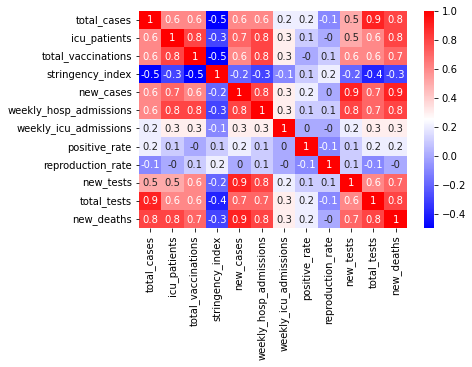

In [17]:
print()
print()
print()
print()
print()
sns.heatmap(data = corr_mat, annot=True, cmap='bwr');